# Neizrazito, evolucijsko i neuro računarstvo - 7. domaća zadaća

Ovdje se nalazi rješenje, a kasnije i izvješće za 7. domaću zadaću iz NENR-a.

## Učitavanje resursa

In [1]:
import os

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import civilization
import minikeras
from util import parse_dataset

## Zadatak 1.

Razmotrite jedan neuron koji ima samo jedan ulaz. Njegov izlaz tada će biti određen izrazom:

$$
y = \frac{1}{1 + \frac{\left| x - w \right|}{\left| s \right|}}
$$

Pretpostavite da je u neuron pohranjena vrijednost $w = 2$. Nacrtajte *na istom grafu* ovisnost $y\left( x; w = 2 \right)$ za tri slučaja: za $s = 1$, za $s = 0.25$ te za $s = 4$ (svaku različitom bojom ili stilom linije). Za raspon apscise uzmite interval $\left[ -8, 10 \right]$. Razumijete li sada kako $s$ utječe na izlaz neurona $y$? Kako će izgledati izlaz neurona koji ima dva ulaza i što se tada kontrolira parametrima $s_1$ i $s_2$?

---

Ovaj zadatak riješit ćemo ovdje, bez uporabe **civilization** ili **minikeras** paketa.

In [4]:
def generate_function(w, s):
    def _y(inputs: np.ndarray):
        return np.reciprocal(1 + np.abs(np.divide(inputs - w, s)))
        
    return _y

In [5]:
task_1_ws = [2]
task_1_ss = [4, 1, 0.25]
task_1_x_interval = (-8, 10 + 1e-6)
task_1_x_axis = np.arange(*task_1_x_interval, 0.1)
task_1_x_ticks = np.arange(*task_1_x_interval, 1.)

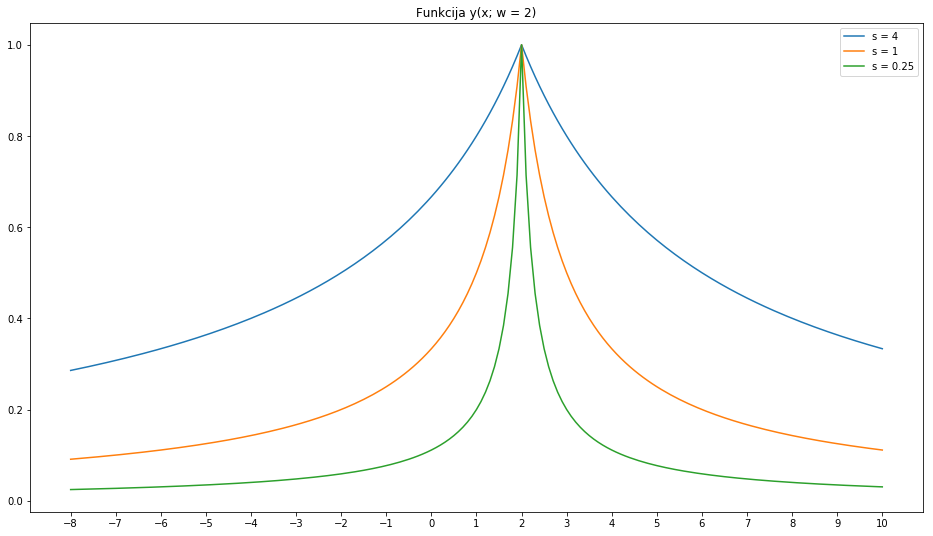

In [6]:
plt.figure(figsize=(16, 9))
plt.title(f"Funkcija y(x; w = 2)")

for w in task_1_ws:
    for s in task_1_ss:
        _function = generate_function(w, s)
        
        plt.xticks(task_1_x_ticks)
        plt.plot(task_1_x_axis, [_function(x) for x in task_1_x_axis], label=f"s = {s}")
        plt.legend()

## Zadatak 2.

Iskoristite neki gotov program (ili napišite vlasitit program, što god Vam je lakše) kako biste dobili 2D prikaz podataka koje ste dobili za učenje (```zad7-dataset.txt```). Pri tome uzorke različitih razreda prikažite ili različitim simbolom (npr. kvadratić, trokutić, kružič) ili različitom bojom. Ovu sliku spremite kao dio Vaše dokumentacije. Ako ste koristili gotov program, navedite naziv programa.

Proučite dobiveni prikaz. Postoji li kakav uzorak u tim podatcima? Jesu li razredi međusobno linearno odvojivi?

---

Ovaj zadatak ćemo lagano riješiti koristeći ```parse dataset``` iz **util.py** i ```plt.scatter```.

In [7]:
task_2_dataset = parse_dataset("data/dataset.tsv")
tr_x, tr_y = zip(*task_2_dataset)

scatter_y = np.array([1 if y[0] == 1 else 2 if y[1] == 1 else 3 for y in tr_y])
scatter_x = [[], [], []]

for i, x in enumerate(tr_x):
    scatter_x[scatter_y[i] - 1].append(x)

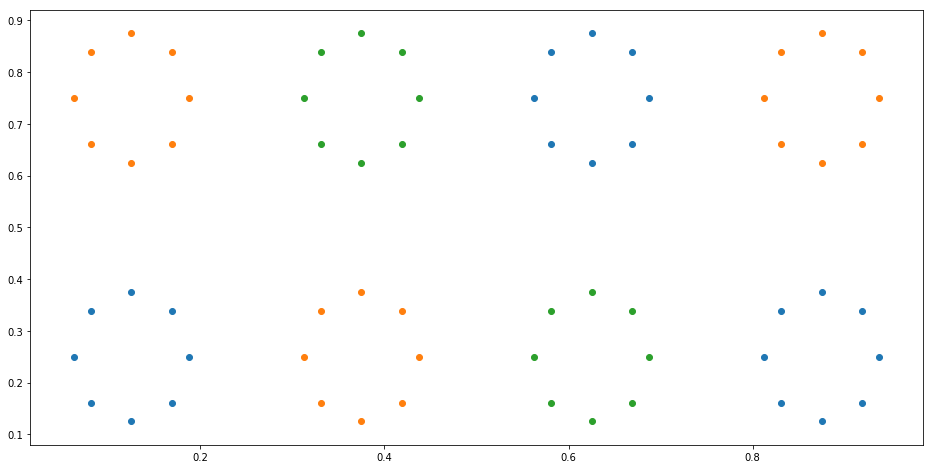

In [8]:
plt.figure(figsize=(16, 8))

for group in scatter_x:
    plt.scatter(*zip(*group))

## Zadatak 3.

Kada biste morali ručno odrediti vrijednosti svih parametara upravo zadane neuronske mreže, na koje biste ih vrijednosti postavili i zašto? Čime biste se vodili prilikom određivanja parametara neurona skrivenog sloja a čime prilikom određivanja parametara neurona izlaznog sloja? Nacrtajte tu neuronsku mrežu i na njoj prikažite vrijednosti svih parametara.

---

- Ulazni sloj
  - nema parametara, prema tome nemamo što postaviti
  
- Skriveni sloj
  - samo jedan sloj tipa $N_1$
  - postavljamo dva parametra: $\vec{w}$ ($2$ parametra) i $s$, i to njih $8$ (jer imamo $8$ neurona), što je ukupno $24$ parametara (tj. $\left( 2 + 1 \right) \cdot 8$ parametara)
  
- Izlazni sloj
  - Običan dense layer s $3$ izlaza, s obzirom na to da prethodni sloj ima $8$ neurona, ovaj sloj ima $24$ težina ($8 \cdot 3$ i $3$ varijable pomaka, ukupno $27$ težina.

### Skriveni sloj

Skrivenom sloju bi trebalo pronaći optimalno raspršenje. Pretpostavljam da će idealna konfiguracija za ovakvu mrežu imati isto raspršenje ($s$) za sve neurone jer je preplitka za bilo što više. Stoga, bit će bitno pronaći optimalne težine za $N_1$ sloj.

Moja pretpostavka je da se ovaj sloj ponaša kao neki izlučivač značajki. S obzirom da su mi dostupni podaci, mogu vidjeti da su dosta strukturirani. Imamo $8$ kružnica, pa ću parametre težina postaviti u središta tih kružnica (ne znam ih napamet, ne vidim ih od oka, neću investirati u pisanje programa koji ih pronalazi).

### Izlazni sloj

Izlazni sloj je jedan potpuno povezani sloj. On će dati $3$ vrijednosti koje, s obzirom da su aktivirane sigmoidom, možemo gledati kao vjerojatnost da je neka točka jedna od $3$ klase. S obzirom na to da smo skriveni sloj definirali kao središta kružnica, to će kao konsekvens imati činjenicu da će aktivacije neurona biti najveće za klasu u čijem se središtu nalaze. Prema tome, ovisno kako poredamo neurone ulaznog sloja, tako ćemo trebati i postaviti težine i pomak, kako bi osigurali da značajke koje je skriveni sloj izlučio najviše pridonesu povećanjem vrijednosti aktivacije neurona kojeg predstavljaju. Konačno, pomaci ovdje ne igraju preveliku ulogu, s obzirom da pomak može pridonijeti samo tome da malo popravi aktivaciju za određenu znamenku izlaza, ali što se tiče utjecaja jedne klase na drugu, tu nema nikakvog utjecaja. Što se mene tiče, pomaci mogu biti $0$. Ako nam je učenje dobro, predviđam da će nam za ovakav skup podataka pomaci biti **jednaki**, a težiti u $+\infty$.

Pretpostavimo da smo centre definirali s lijeva na desno, od gore prema dolje. Onda mogu reći da je raspodjela grupa sljedeća:

- grupa $1$: $\left[ 3, 5, 8 \right]$
- grupa $2$: $\left[ 1, 4, 6 \right]$
- grupa $3$: $\left[ 2, 7 \right]$

Recimo da su težine simboličke, tj. da promatramo samo njihov odnos. Reprezentirat ćemo ih s $0$ ili $1$, jer jednostavno, ako određena značajka nije centrirana u klasi koja nas interesira, možemo poništiti njezin doprinos, a one koje jesu priznati. Onda će matrica težina glasiti:

<br>

$$
\vec{w} = 
\begin{vmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
\end{vmatrix}
$$

<br>

dok će težine biti vektor

<br>

$$
\vec{b} = \left[ x, x, x\right]
$$

<br>

gdje je x neki skalar za koji vrijedi

<br>

$$
{x \rightarrow +\infty}
$$

Finalno, da se uočiti da će za ovakvu mrežu skriveni sloj izlučivati značajke, tj. govoriti nam o prototipima klastera neke klase, dok će izlazni sloj poništavati aktivacije prethodnog sloja nevezane uz središta klase koju pokušavaju reprezentirati net sumom, a pomaci će naše vrijednosti, zbog korištenja sigmoide pokušati približiti vrijednosti $1$ što više mogu, ne bi li srednja kvadratna pogreška bili što manja.

Iz ovoga je također vidljivo da će optimalan trening ovakve mreže uključivati postavljanje $\vec{b} = \left[ 0, 0, 0\right]$ te zamrzavanje tih vrijednosti, pa će se pri kraju treninga zamrznuti svi ostali parametri, a trenirati $\vec{b}$ kako bi se minimizirala pogreška.